In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm, trange
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
from importlib import reload

import oscdetector as od
import hhinfo

# Validate TE method usign test signal

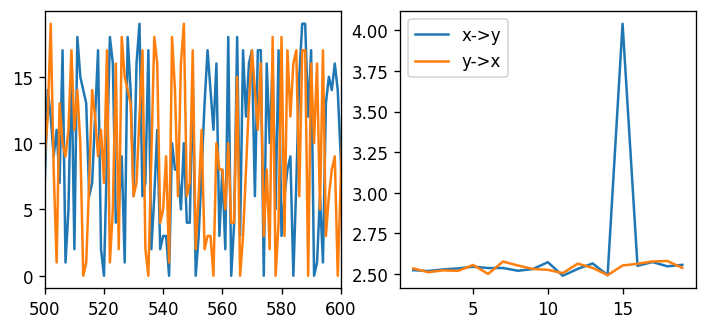

In [2]:
x = np.random.rand(1000)
nbin = 20

e = np.linspace(0, 1, nbin+1)
xd = np.digitize(x, e)-1
yd = np.array(list(xd[-15:]) + list(xd[:-15]))

te_xy, hy = hhinfo.compute_te(xd, yd, nbin, 20)
te_yx, hx = hhinfo.compute_te(yd, xd, nbin, 20)

plt.figure(figsize=(7, 3))
plt.subplot(121)
plt.plot(xd)
plt.plot(yd)
plt.xlim([500, 600])

plt.subplot(122)
plt.plot(np.arange(1, 20), te_xy[1:], label="x->y")
plt.plot(np.arange(1, 20), te_yx[1:], label="y->x")
plt.legend()
plt.show()

In [ ]:
with open(

# Validate TE result with changing LFP variables:
- bin size (LFP)
- time lag
- number of oscillation motif
- verify sampling rates

In [3]:
def digitize_v(v, vrange, nbin):
    v[v < vrange[0]] = vrange[0]
    v[v > vrange[1]] = vrange[1]
    
    de = (vrange[1] - vrange[0])/(nbin-1)
    e = np.arange(vrange[0]-de/2, vrange[1]+de, de)
    
    return np.digitize(v, e)


srate = 2000
vrange = [-70, -50]

summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data")

key_names = ("fpop", "spop")
amp_range_set = [
    dict(fpop=[[]], spop=[[]]), # 1
    dict(fpop=[[]], spop=[[]]), # 2
    dict(fpop=[[20, 30], [40, 50]],
         spop=[[20, 30]]), # 3
    dict(fpop=[[30, 40], [50, 70]],
         spop=[[30, 40]]), # 4
    dict(fpop=[[], [60, 70]],
         spop=[[25, 35], [60, 70]]), # 5 -> tuned
    dict(fpop=[[50, 70]], 
         spop=[[20, 40], [50, 70]]), # 6
    dict(fpop=[[60, 70]],
         spop=[[60, 70]]), # 7
    dict(fpop=[[30, 40], [60, 70]],
         spop=[[30, 40], [60, 70]]), # 8 -> tuned
]

Load cache file


## Changing (bin size) + (time lag) + (sampling rate)

  0%|          | 0/200 [00:00<?, ?it/s]

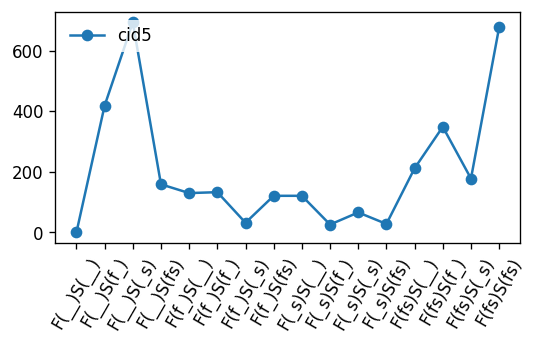

In [6]:
# profile oscillation motif

cid = 8
amp_range = amp_range_set[cid-1]

words_len = [[] for _ in range(16)]
# word_counts = np.zeros(16)
for i in trange(200):
    detail_data = summary_obj.load_detail(cid-1, i)
    psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01, wbin_t=0.5)
    words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=80, min_len=2, cat_th=2)
    
    osc_motif_set = od.get_motif_boundary(words, tpsd)
    for osc_motif in osc_motif_set:
        d = osc_motif["range"][1] - osc_motif["range"][0]
        words_len[osc_motif["id"]].append(d)

words_count = [len(w) for w  in words_len]

plt.figure(figsize=(5, 2.5))
plt.plot(words_count, 'o-', label="cid5")
plt.xticks(np.arange(16), od.get_motif_labels(), rotation=60)
plt.legend(loc="upper left", edgecolor="none")
plt.show()

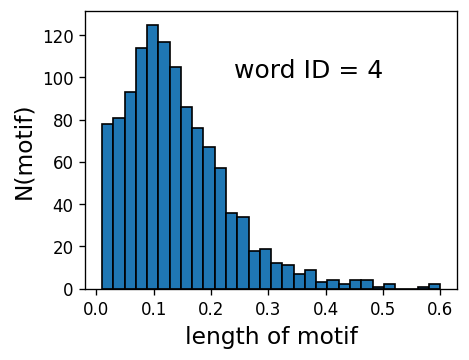

In [64]:
word_id = 4

plt.figure(figsize=(4, 3))
plt.hist(words_len[word_id], 30, edgecolor='k')
plt.xlabel("length of motif", fontsize=14)
plt.ylabel("N(motif)", fontsize=14)
plt.text(0.5, 100, "word ID = %d"%(word_id), ha="right", fontsize=15)
plt.show()

In [30]:
# load validation data
with open("./data/te_validation_2000.pkl", "rb") as fp:
    te_data = pkl.load(fp)

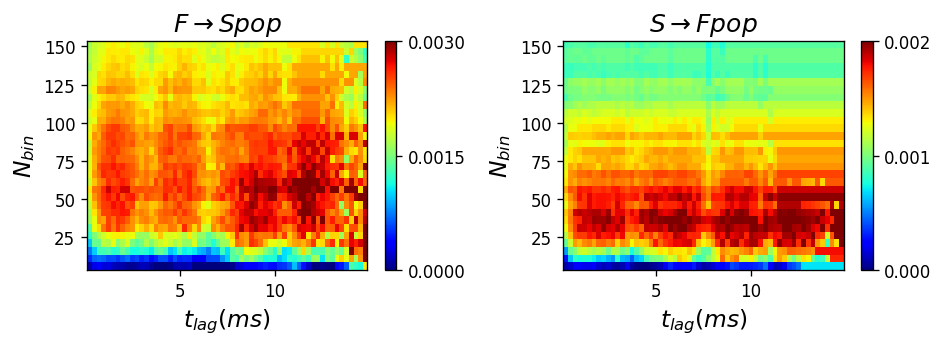

In [229]:
lb_dir = (r"$F \rightarrow S pop$", r"$S \rightarrow F pop$")
vmax_dir = [3e-3, 2e-3]

plt.figure(figsize=(8, 3))
for i in range(2):
    plt.subplot(1,2,i+1)
    hhtools.imshow_xy(np.average(te_data["te"], axis=0)[i][:,1:],
                      y=te_data["bin_size"], x=te_data["tlag"][1:]/2,
                      vmin=0, vmax=vmax_dir[i],
                      cmap="jet")
    plt.xlabel(r"$t_{lag} (ms)$", fontsize=14)
    plt.ylabel(r"$N_{bin}$", fontsize=14)
    # plt.colorbar(ticks=[0, 0.0015, 0.003])
    plt.colorbar(ticks=np.linspace(0, vmax_dir[i], 3))

    plt.title(lb_dir[i], fontsize=15)

plt.tight_layout()
plt.show()

In [216]:
id_binsize = 9
np.random.seed(100)

m1 = 0
m2 = 0

npoints = np.arange(1, N, 10)
te_avg = np.zeros([len(npoints), 2, te_data["te"].shape[3]])
N = te_data["te"].shape[0]
for i, n in enumerate(npoints):
    idx = np.random.randint(low=0, high=N-1, size=n)
    te_avg[i] = te_data["te"][idx,:,id_binsize,:].mean(axis=0)
    
te_avg = np.swapaxes(te_avg, 0, 1) 

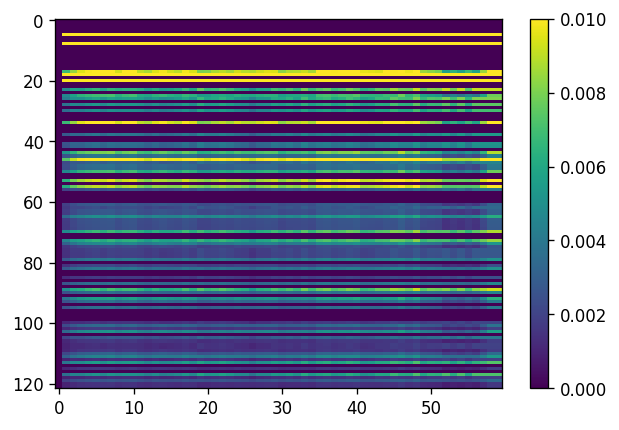

In [227]:
plt.figure(figsize=(6, 4))
plt.imshow(te_avg[0], aspect="auto", vmax=0.01, vmin=0)
plt.colorbar()
plt.show()